In [41]:
import matplotlib.pyplot as plt
import pickle
import torch
import numpy as np
import seaborn as sns

In [42]:

with open('/mnt/data/deka01/debug_OpenPCDet/tools/features_no_cpcl_iteration.pkl', 'rb') as file:
    loaded_data = pickle.load(file)


In [43]:
loaded_data['ens'][0].keys()

dict_keys(['shared_features_gt', 'pooled_features_gt', 'instance_idx', 'gt_classes', 'gt_boxes', 'sample_idx'])

#### utils

In [44]:
def gather_features(loaded_data):
    sh_list = []
    gt_classes_list = []
    instance_idx_list = []
    ret_dict = {}
    for data in loaded_data['ens']:
        gt_sh = torch.tensor(data['shared_features_gt'])
        gt_classes = torch.tensor(data['gt_classes'])
        instance_id = torch.tensor(data['instance_idx'])
        sh_list.append(gt_sh)
        gt_classes_list.append(gt_classes)
        instance_idx_list.append(instance_id)

        # Convert to tensors
    class_sh = torch.cat(sh_list)
    class_gt = torch.cat(gt_classes_list)
    instance_idx = torch.cat(instance_idx_list)
    ret_dict.update({'sh': class_sh, 'gt_classes': class_gt, 'instance_idx': instance_idx})
    return ret_dict


In [45]:
def sort_instances(ret_dict):

    instance_idx = ret_dict['instance_idx']
    sorted_idx = torch.argsort(instance_idx)

    # Create a dictionary with sorted values as keys and sorted lists of indices as values
    sorted_dict = {}
    for idx, value in enumerate(instance_idx[sorted_idx]):
        value = value.item()
        if value not in sorted_dict:
            sorted_dict[value] = []
        sorted_dict[value].append(sorted_idx[idx].item())

    # Sort the lists of indices
    for value in sorted_dict:
        sorted_dict[value].sort()
        sorted_dict[value] = torch.tensor(sorted_dict[value][0]) # select the first occurence of the instance
    sorted_tensor = torch.stack(list(sorted_dict.values()))
    return sorted_tensor




#### sort by instance ids and select the first occurance

In [46]:
ret_dict = gather_features(loaded_data)
selected_inds = sort_instances(ret_dict)

In [47]:
selected_sh = ret_dict['sh'][selected_inds]
selected_gt = ret_dict['gt_classes'][selected_inds]

#### PCA

/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/matplotlib/collections.py:1096: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


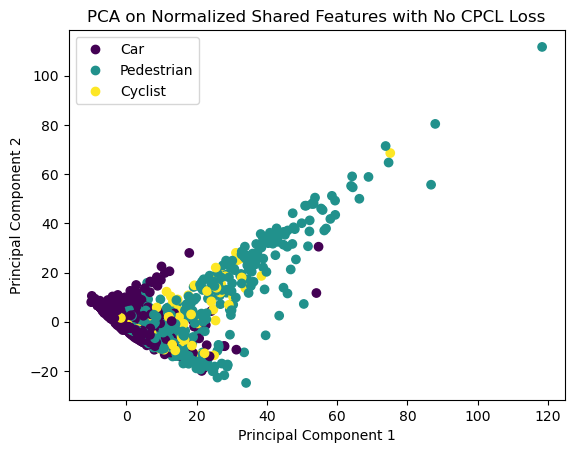

In [50]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Create a sample dataset
x = selected_sh.cpu().numpy()
y = selected_gt.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform PCA on normalized features
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Normalized Shared Features with No CPCL Loss')

## Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=np.unique(y))
legend = plt.legend(handles, class_names)
plt.show()


/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [20:30:24.492735] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/matplotlib/collections.py:1096: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


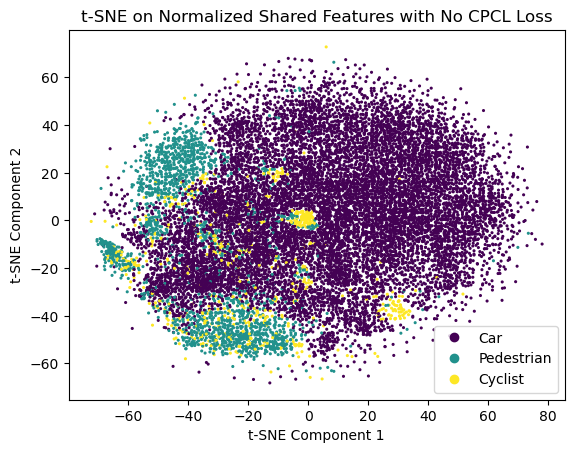

In [51]:
import cupy as cp
import matplotlib.pyplot as plt
from cuml.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh.cpu().numpy()
y = selected_gt.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Convert normalized data to CuPy array
x_normalized_cupy = cp.array(x_normalized)

# Perform t-SNE on normalized features
tsne_gpu = TSNE(n_components=2, perplexity=30, learning_rate=150, n_iter=1000, random_state=0)
x_tsne = tsne_gpu.fit_transform(x_normalized_cupy)
x_tsne = cp.asnumpy(x_tsne)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE on Normalized Shared Features with No CPCL Loss')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=np.unique(y))
legend = plt.legend(handles, class_names)
plt.show()


In [54]:
with open('/mnt/data/deka01/debug_OpenPCDet/tools/features_with_cpcl_iteration.pkl', 'rb') as file:
    loaded_data_cpcl = pickle.load(file)



In [55]:
ret_dict_cpcl = gather_features(loaded_data_cpcl)
selected_inds = sort_instances(ret_dict_cpcl)
selected_sh_cpcl = ret_dict_cpcl['sh'][selected_inds]
selected_gt_cpcl = ret_dict_cpcl['gt_classes'][selected_inds]

/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/matplotlib/collections.py:1096: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


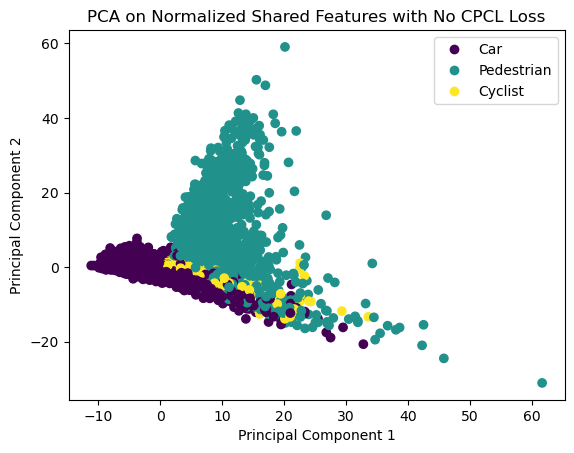

In [56]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Create a sample dataset
x = selected_sh_cpcl.cpu().numpy()
y = selected_gt_cpcl.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform PCA on normalized features
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Normalized Shared Features with No CPCL Loss')

## Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=np.unique(y))
legend = plt.legend(handles, class_names)
plt.show()


/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [21:07:09.036498] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/matplotlib/collections.py:1096: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


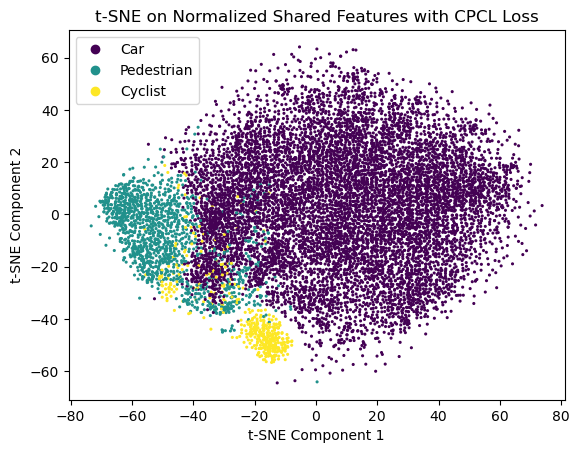

In [80]:
import cupy as cp
import matplotlib.pyplot as plt
from cuml.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh_cpcl.cpu().numpy()
y = selected_gt_cpcl.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Convert normalized data to CuPy array
x_normalized_cupy = cp.array(x_normalized)

# Perform t-SNE on normalized features
tsne_gpu = TSNE(n_components=2, perplexity=30, learning_rate=150, n_iter=1000, random_state=0)
x_tsne = tsne_gpu.fit_transform(x_normalized_cupy)
x_tsne = cp.asnumpy(x_tsne)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE on Normalized Shared Features with CPCL Loss')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=np.unique(y))
legend = plt.legend(handles, class_names)
plt.show()


#### Plotting 3d t-SNE(Optional)

In [83]:
import cupy as cp
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh_cpcl.cpu().numpy()
y = selected_gt_cpcl.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features (3D embedding)
tsne = TSNE(n_components=3, perplexity=30, learning_rate=150, n_iter=1000, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a DataFrame for Plotly
data = {
    'x': x_tsne[:, 0],
    'y': x_tsne[:, 1],
    'z': x_tsne[:, 2],
    'label': y
}
df = pd.DataFrame(data)




In [89]:
# Create a Plotly 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', symbol='label', title='t-SNE on Normalized Shared Features with CPCL Loss')

# Update the color scale and symbol map
fig.update_traces(marker=dict(size=3))

# Save the interactive 3D graph as an HTML file
fig.write_html("/mnt/data/deka01/debug_OpenPCDet/tools/interactive_3d_graph_with_loss.html")


In [90]:
import cupy as cp
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh.cpu().numpy()
y = selected_gt.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features (3D embedding)
tsne = TSNE(n_components=3, perplexity=30, learning_rate=150, n_iter=1000, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a DataFrame for Plotly
data = {
    'x': x_tsne[:, 0],
    'y': x_tsne[:, 1],
    'z': x_tsne[:, 2],
    'label': y
}
df = pd.DataFrame(data)

In [ ]:
# Create a Plotly 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', symbol='label', title='t-SNE on Normalized Shared Features without CPCL Loss')

# Update the color scale and symbol map
fig.update_traces(marker=dict(size=3))

# Save the interactive 3D graph as an HTML file
fig.write_html("/mnt/data/deka01/debug_OpenPCDet/tools/interactive_3d_graph_without_loss.html")
